In [1]:
import time
import torch
import numpy as np
import matplotlib.pyplot as pl
import torchdiffeq
import torch.nn as n
import FrEIA.framework as Ff
import FrEIA.modules as Fm
from mpl_toolkits import mplot3d


##########################################################3
# system dynamics

xx=torch.tensor([0.,0.,0.])
tt=torch.tensor([0.,5.])
t_d=torch.linspace(0,2,800)
devicestr="cpu"
device_str="cuda"

In [2]:
xx.to(device_str)

tensor([0., 0., 0.], device='cuda:0')

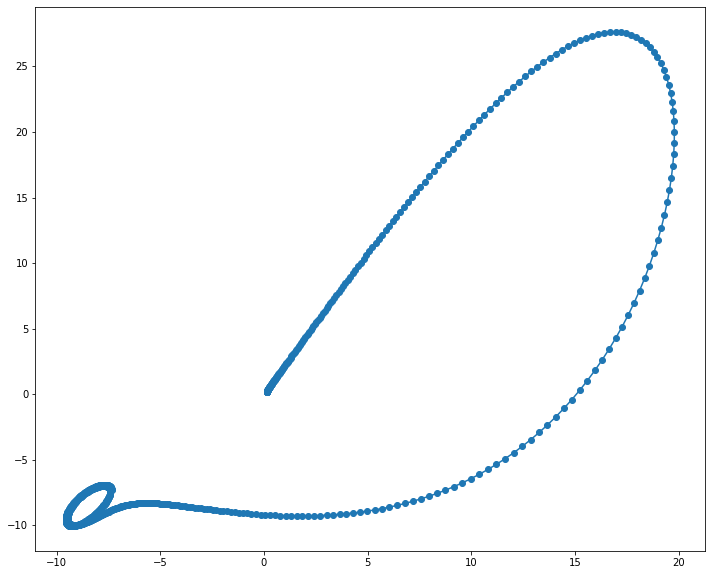

In [3]:
def test_fun(t,x):
    sig=10.
    rho=28.
    beta=8/3
    vel=torch.zeros((3,1))
    vel[0]=sig*(x[1]-x[0])
    vel[1]=x[0]*(rho-x[2])-x[1]
    vel[2]=x[0]*x[1]-beta*x[2]
    return(vel)

tt_tors=torch.tensor([[.15,.15,.15,0.,0.,0.]])
xy_d_list=[]
for i in range(len(tt_tors)):
    noise_c=torch.normal(torch.zeros((len(t_d),3)),0.01*torch.ones((len(t_d),3)))
    xy_d=torchdiffeq.odeint(test_fun,tt_tors[i,:3][None].T,t_d).reshape((-1,3))#+noise_c #no noise for test
    xy_d_list.append(xy_d.clone().detach())

pl.figure(figsize=(12,10))
for i in range(len(xy_d_list)):
    xy_d=xy_d_list[i]
    pl.plot(xy_d[:,0],xy_d[:,1],marker='o')

xx=xy_d_list[0] 

In [14]:
N_DIM = 6
def subnet_fc(dims_in, dims_out):
    return n.Sequential(n.Linear(dims_in, 1500), n.ReLU(),
                         n.Linear(1500, dims_out))
inn2 = Ff.SequenceINN(N_DIM)
for k in range(5):
    inn2.append(Fm.AllInOneBlock, subnet_constructor=subnet_fc)
    
f_x_base=n.Sequential(
n.Linear(6, 30),
n.Tanh(),
n.Linear(30, 30),
n.Tanh(),
n.Linear(30, 30),
n.Tanh(),
n.Linear(30, 6)
)
def fx_base(t,x):
    return(f_x_base(x))
    
def for_inn2(x):
    return(inn2(x)[0])
def rev_inn2(x):
    return(inn2(x,rev=True)[0])
def linear_val_ode2(init_v,t_d):
    init_v_in=rev_inn2(init_v)
    eval_lin=torchdiffeq.odeint(fx_base,init_v_in,t_d,
                                method='dopri5')[:,0,:]#options={'step_size':0.01}
    eval_out=for_inn2(eval_lin)
    return(eval_out)
    
f_x_base.load_state_dict(torch.load('f_x_base_save_good_eod2.tar'))
inn2.load_state_dict(torch.load('inn2_save_good_eod2.tar'))   
f_x_base = f_x_base.to(device_str)
inn2 = inn2.to(device_str)

f_x_base = f_x_base.to(device_str)
tt_tors = tt_tors.to(device_str)
t_d = t_d.to(device_str)
    
time_list=[]
for i in range(10):
        tic = time.perf_counter()
        tx=linear_val_ode2(tt_tors,t_d)
        toc = time.perf_counter()
        time_list.append(toc-tic)


ours=np.array(time_list)
print('ours time mean:')
print(ours.mean())
print('ours time std:')
print(ours.std())


sum_num=0
    
for i in range(0,len(tt_tors)):
    xy_d=xy_d_list[i]
    print(xy_d.shape)
    error=torch.mean(torch.norm(tx[:,:3].to('cpu')-xy_d,dim=1))
    sum_num+=error
    
print(f'Ours Interpolation MAE: {sum_num:.4f}')


ours time mean:
0.22950457169972652
ours time std:
0.009007374154333092
torch.Size([800, 3])
Ours Interpolation MAE: 0.2012
